<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exploratory-Data-Analysis-and-Metric" data-toc-modified-id="Exploratory-Data-Analysis-and-Metric-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exploratory Data Analysis and Metric</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Submit" data-toc-modified-id="Submit-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Submit</a></span></li><li><span><a href="#Homework" data-toc-modified-id="Homework-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Homework</a></span></li></ul></div>

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing  import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score


In [2]:
SEED = 42

**[Kaggle InClass: Language Detection](https://www.kaggle.com/c/introml2020-3)**

# Exploratory Data Analysis and Metric

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
train_df.shape, test_df.shape

((3159633, 2), (2784634, 2))

In [5]:
train_df.head(15)

,sentence,language
0,"Pensez à la communication , le discours , les ...",fr
1,"Můžete si ji pronajmout , vzít na splátky , ko...",cs
2,"Každý starosta pochopil , že když mají tyto fo...",cs
3,"Det är ytterligare bevis , men ändå — Jag krit...",sv
4,كان الأمر لا يصدق .,ar
5,"Na primjer , pjesnik ga opisuje ovako .",hr
6,Semua rerumputan itu sekarang menutupi tanah s...,id
7,Det är en enorm utmaning för oss att göra det .,sv
8,Ono što ćete vidjeti - trebat ćete skočiti ovd...,hr
9,( Alqışlar ) Excel-dən istifadə etmişəm .,az


In [6]:
lang_count = (
    train_df.language.value_counts()
    .to_frame()
    .reset_index()
)

lang_count.head()

,index,language
0,ru,181970
1,en,157655
2,fr,148585
3,vi,113193
4,ar,110032


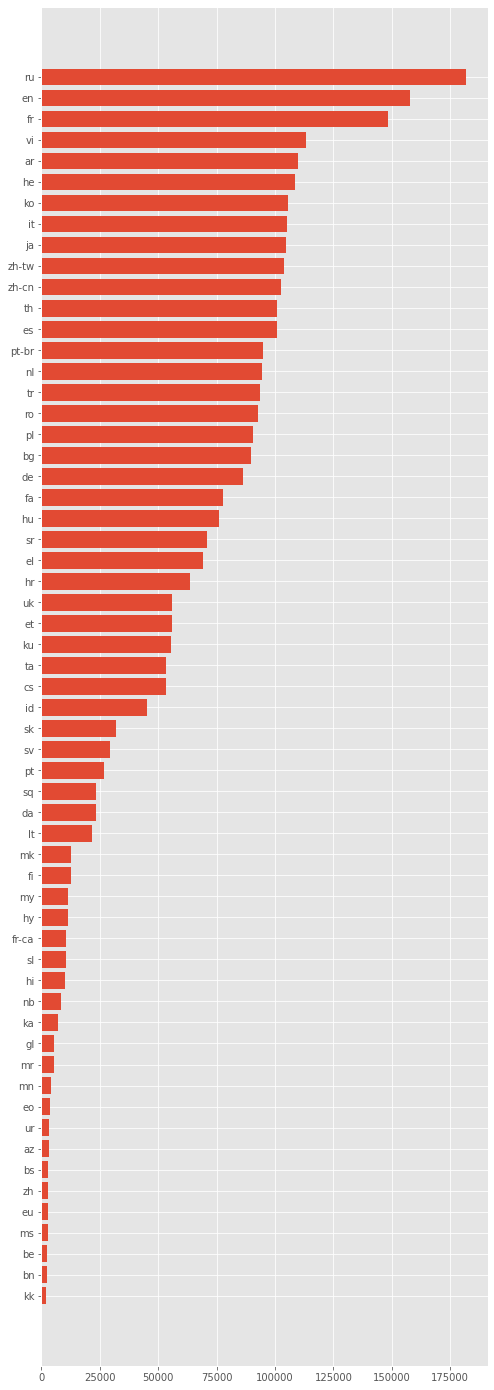

In [7]:
fig, ax = plt.subplots(figsize=(8,25))

ax.barh(lang_count['index'], lang_count['language'])
ax.invert_yaxis();

In [8]:
lang_count[lang_count['index'].apply(lambda x: x in {"en", "kk"})]

,index,language
1,en,157655
58,kk,2046


Датасет сильно не сбалансирован по классам, а требуется хорошее качество для всех языков, поэтому метрика в данном соревновании — взвешенная доля правильных ответов:

$$ 
\text{WeightedAccuracy}\left(y, \hat{y}, w\right) = \frac{\displaystyle{\sum_{i=1}^{n}} w_i \cdot \left(y_i == \hat{y}_i\right)}{\displaystyle\sum_{i=1}^{n} w_i } 
$$

Веса выбирались обратно пропорционально количеству примеров соответствующего языка:
$$
w\left(\text{"en"}\right) \sim \frac{1}{157655}
$$
$$ \dots $$
$$
w\left(\text{"kk"}\right) \sim \frac{1}{2046}
$$

Поэтому для валидации можно использовать [sklearn.metrics.balanced_accuracy_score](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score)

# Model

In [17]:
x = train_df.values[:1500000,  0]
label_encoder = LabelEncoder().fit(train_df.values[:, 1])
y = label_encoder.transform(train_df.values[:1500000, 1])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

In [12]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer='char', lowercase=True, min_df=2, max_df=0.8, ngram_range=(2, 3))),
    ('clf', SGDClassifier(random_state=SEED, loss='log', n_jobs=-1))
])

In [19]:
params = {'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 3), (3, 3), (3, 4)]}

In [20]:
gs_pipeline = GridSearchCV(pipe, params, cv=3, n_jobs=-1)

In [21]:
gs_pipeline.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='char',
                                                        max_df=0.8, min_df=2)),
                                       ('model',
                                        SGDClassifier(loss='log', n_jobs=-1,
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid={'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 3),
                                                     (3, 3), (3, 4)]})

In [23]:
gs_pipeline.best_params_

{'vectorizer__ngram_range': (2, 3)}

In [24]:
gs_pipeline.cv_results_

{'mean_fit_time': array([ 432.88693897,  990.14605165, 1721.36972864, 1053.25591938,
        1866.5380923 ]),
 'std_fit_time': array([ 1.16713152, 55.31672804, 88.64523305, 44.40849622, 56.46678688]),
 'mean_score_time': array([ 73.02564772, 319.33223128, 607.11599549, 258.61421569,
        367.49372697]),
 'std_score_time': array([  1.68469495,  28.66323711,  50.47713829,  40.97999433,
        203.07534679]),
 'param_vectorizer__ngram_range': masked_array(data=[(1, 1), (1, 2), (2, 3), (3, 3), (3, 4)],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'vectorizer__ngram_range': (1, 1)},
  {'vectorizer__ngram_range': (1, 2)},
  {'vectorizer__ngram_range': (2, 3)},
  {'vectorizer__ngram_range': (3, 3)},
  {'vectorizer__ngram_range': (3, 4)}],
 'split0_test_score': array([0.85968  , 0.909955 , 0.9095375, 0.886335 , 0.87506  ]),
 'split1_test_score': array([0.8593175, 0.909585 , 0.9101125, 0.8871025, 0.8756225]),
 'spli

In [7]:
x = train_df.values[:,  0]
label_encoder = LabelEncoder().fit(train_df.values[:, 1])
y = label_encoder.transform(train_df.values[:, 1])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

In [8]:
vectorizer = TfidfVectorizer(analyzer='char', lowercase=True, min_df=2, max_df=0.8, ngram_range=(2, 3))

In [9]:
x_train = vectorizer.fit_transform(x_train)

In [10]:
x_test = vectorizer.transform(x_test)

In [11]:
# from scipy import sparse

# sparse.save_npz("x_train.npz", x_train)
# sparse.save_npz("x_test.npz", x_test)

# # x_train = sparse.load_npz("x_train.npz")

In [12]:
one_hot_encoder = OneHotEncoder().fit(np.expand_dims(y_train, axis=1))
y_train_one_hot = one_hot_encoder.transform(np.expand_dims(y_train, axis=1))

In [17]:
svc = LinearSVC(max_iter=2000)

In [18]:
svc_gs =  GridSearchCV(svc, {'C': [0.1, 0.5, 1]}, scoring='f1', cv=3, n_jobs=-1)

In [ ]:
svc_gs.fit(x_train, y_train_one_hot)

In [ ]:
balanced_accuracy_score(y_train, svc_gs.best_estimator_.predict(x_train))

In [ ]:
balanced_accuracy_score(y_test, svc_gs.best_estimator_.predict(x_test))

In [ ]:
svc_gs.best_params_

In [4]:
#submition

In [6]:
train_df = train_df[train_df['sentence'] != '-']

In [9]:
test_df['sentence'] = test_df['sentence'].apply(lambda sentence: "".join(re.sub(r'[^\w\s]+|[\d]+', r'', sentence).strip()))
train_df['sentence'] = train_df['sentence'].apply(lambda sentence: "".join(re.sub(r'[^\w\s]+|[\d]+', r'', sentence).strip()))
train_df['sentence'].head(10)

0    Pensez à la communication  le discours  les ge...
1    Můžete si ji pronajmout  vzít na splátky  koup...
2    Každý starosta pochopil  že když mají tyto for...
3    Det är ytterligare bevis  men ändå  Jag kritis...
4                                    كان الأمر لا يصدق
5                 Na primjer  pjesnik ga opisuje ovako
6    Semua rerumputan itu sekarang menutupi tanah s...
7        Det är en enorm utmaning för oss att göra det
8    Ono što ćete vidjeti  trebat ćete skočiti ovdj...
9                  Alqışlar  Exceldən istifadə etmişəm
Name: sentence, dtype: object

In [10]:
x_train = train_df.values[:,  0]
label_encoder = LabelEncoder().fit(train_df.values[:, 1])
y_train = label_encoder.transform(train_df.values[:, 1])

In [11]:
vectorizer = TfidfVectorizer(analyzer='char', lowercase=True, min_df=4, max_df=0.8, ngram_range=(2, 3))

In [12]:
x_train = vectorizer.fit_transform(x_train)

In [13]:
x_test = test_df.values[:,  1]
x_test = vectorizer.transform(x_test)

In [14]:
sgd = SGDClassifier(random_state=SEED, class_weight='balanced', loss='log', n_jobs=-1)

In [15]:
sgd.fit(x_train, y_train)

SGDClassifier(class_weight='balanced', loss='log', n_jobs=-1, random_state=42)

In [16]:
########

In [ ]:
estimators = [
     ('rf', RandomForestClassifier(n_estimators=100, max_features='sqrt', n_jobs=-1, verbose=True, class_weight='balanced')),
     ('svc', LinearSVC()),
     ('mnb', MultinomialNB()),
     ('logreg', LogisticRegression( n_jobs=-1))
]

In [ ]:
clf = StackingClassifier(n_jobs=-1, estimators=estimators, final_estimator=XGBClassifier(learning_rate=0.1, n_estimators=50, n_jobs=-1), cv=3)

In [ ]:
parameters = {
              'n_estimators': [10, 50, 70, 100]
}
gs_pipeline = GridSearchCV(clf, parameters, cv=3)

# Submit

In [17]:
submit_predictions = sgd.predict(x_test)

In [18]:
test_df['language'] = label_encoder.classes_[submit_predictions]

test_df.head()

,index,sentence,language
0,0,תודה לכם,he
1,1,Precisamos de compaixão para começar e autoin...,pt-br
2,2,這個增長相當大 並且它將引發經濟的增長,zh-tw
3,3,시애틀에서 자란 제가 처음 가난을 보게 되던 때를 기억해요,ko
4,4,これをロボットに組み込みました,ja


In [19]:
(
    test_df[['index',  'language']]
    .to_csv('sample_submission.csv', index=False)
)

In [20]:
!head $sample_submission.csv

head: .csv: No such file or directory
